In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img#載入圖片需宣告這個
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras import optimizers
import os
import random
import scipy
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,roc_auc_score,auc
import numpy as np
import cv2

/home/cheyu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def history_plot(results): 
    # list all data in history
    print(results.history.keys())
    # summarize history for accuracy
    plt.figure(1)
    plt.plot(results.history['acc'])
    plt.plot(results.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('Accuracy',dpi=300)
    plt.show()

    # summarize history for loss
    plt.figure(2)
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot(np.argmin(results.history["val_loss"]), 
             np.min(results.history["val_loss"]), 
             marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();
    plt.savefig('Loss',dpi=300)
    plt.show()

In [3]:
#flow_from_directory目錄需要分3類
train_cell = './dataset-master/images/TRAIN/train_cell'
valid_cell = './dataset-master/images/TEST/test_cell'
test_cell = './dataset-master/images/TEST_SIMPLE/'


In [4]:
# Setting the default value
# dimensions of our images.
img_width, img_height = 240, 320
batch_size = 32
epochs = 100
seed = 42
class_mode = 'binary'
date = '2019-03-15_1'


In [5]:
#ImageDataGenerator
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range = 90,  #图片随机转动的角度
                             width_shift_range = 0.2, #图片水平偏移的幅度
                             height_shift_range = 0.2, #图片竖直偏移的幅度
                             zoom_range = 0.3)

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_cell,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = class_mode)

validation_generator = datagen.flow_from_directory(
        valid_cell,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode = class_mode,
        shuffle = False ,
        seed = seed)

# test_generator = datagen.flow_from_directory(
#         test_cell,
#         target_size = (img_width, img_height),
#         batch_size = 1,
#         class_mode = None,
#         shuffle = False,
#         seed = seed
#         )

Found 4980 images belonging to 2 classes.
Found 1243 images belonging to 2 classes.


In [6]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

/home/cheyu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(240, 320,...)`
  
/home/cheyu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  
/home/cheyu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.


In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 318, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 318, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 159, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 157, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 117, 157, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 78, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 76, 64)        18496     
__________

In [9]:
# 設定checkpoint & callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
def callbacks(name):
    save_dir = "checkpoint"
    #     tl.files.exists_or_mkdir(save_dir)
    path=save_dir+'/model_check_'+name+'.h5'
    callbacks = [
#         EarlyStopping(patience=15, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.000001, verbose=1),
        ModelCheckpoint(path, verbose=1, save_best_only=True, save_weights_only=False)
#         ModelCheckpoint(path,monitor='val_acc', verbose=1,
#                         save_best_only=True, save_weights_only=False)
    ]
    return callbacks

In [10]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True)  # randomly flip the images

# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_cell,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle = True,
        seed = seed)

Found 4980 images belonging to 2 classes.


In [11]:
num_of_train_samples  =  train_generator_augmented.classes.shape[0]
num_of_test_samples = validation_generator.classes.shape[0]

In [12]:
history = model.fit_generator(
        train_generator_augmented,
        steps_per_epoch= batch_size,
        validation_data=validation_generator,
        validation_steps= batch_size,
        epochs = epochs,
        callbacks=callbacks(date+'_fit'))

Epoch 1/100
32/32 [==============================] - 68s 2s/step - loss: 0.8064 - acc: 0.5029 - val_loss: 0.6907 - val_acc: 0.6035

Epoch 00001: val_loss improved from inf to 0.69074, saving model to checkpoint/model_check_2019-03-15_1_fit.h5
Epoch 2/100
32/32 [==============================] - 65s 2s/step - loss: 0.7083 - acc: 0.5322 - val_loss: 0.6902 - val_acc: 0.6192

Epoch 00002: val_loss improved from 0.69074 to 0.69015, saving model to checkpoint/model_check_2019-03-15_1_fit.h5
Epoch 3/100
32/32 [==============================] - 64s 2s/step - loss: 0.6975 - acc: 0.5439 - val_loss: 0.6904 - val_acc: 0.6438

Epoch 00003: val_loss did not improve from 0.69015
Epoch 4/100
32/32 [==============================] - 65s 2s/step - loss: 0.6857 - acc: 0.5645 - val_loss: 0.6558 - val_acc: 0.5859

Epoch 00004: val_loss improved from 0.69015 to 0.65583, saving model to checkpoint/model_check_2019-03-15_1_fit.h5
Epoch 5/100
32/32 [==============================] - 64s 2s/step - loss: 0.6845 


Epoch 00038: val_loss did not improve from 0.15122
Epoch 39/100
32/32 [==============================] - 66s 2s/step - loss: 0.1737 - acc: 0.9564 - val_loss: 0.1579 - val_acc: 0.9097

Epoch 00039: val_loss did not improve from 0.15122
Epoch 40/100
32/32 [==============================] - 63s 2s/step - loss: 0.2344 - acc: 0.9639 - val_loss: 0.1655 - val_acc: 0.9160

Epoch 00040: val_loss did not improve from 0.15122
Epoch 41/100
32/32 [==============================] - 65s 2s/step - loss: 0.2031 - acc: 0.9502 - val_loss: 0.1588 - val_acc: 0.9313

Epoch 00041: val_loss did not improve from 0.15122
Epoch 42/100
32/32 [==============================] - 69s 2s/step - loss: 0.0634 - acc: 0.9736 - val_loss: 0.2573 - val_acc: 0.8597

Epoch 00042: val_loss did not improve from 0.15122
Epoch 43/100
32/32 [==============================] - 69s 2s/step - loss: 0.1411 - acc: 0.9619 - val_loss: 0.1313 - val_acc: 0.9274

Epoch 00043: val_loss improved from 0.15122 to 0.13130, saving model to checkpo

32/32 [==============================] - 77s 2s/step - loss: 0.0153 - acc: 0.9961 - val_loss: 0.1015 - val_acc: 0.9460

Epoch 00081: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00081: val_loss did not improve from 0.09217
Epoch 82/100
32/32 [==============================] - 90s 3s/step - loss: 0.0183 - acc: 0.9912 - val_loss: 0.0967 - val_acc: 0.9529

Epoch 00082: val_loss did not improve from 0.09217
Epoch 83/100
32/32 [==============================] - 80s 2s/step - loss: 0.0127 - acc: 0.9961 - val_loss: 0.1136 - val_acc: 0.9362

Epoch 00083: val_loss did not improve from 0.09217
Epoch 84/100
32/32 [==============================] - 82s 3s/step - loss: 0.0135 - acc: 0.9941 - val_loss: 0.1320 - val_acc: 0.9355

Epoch 00084: val_loss did not improve from 0.09217
Epoch 85/100
32/32 [==============================] - 88s 3s/step - loss: 0.0110 - acc: 0.9961 - val_loss: 0.1663 - val_acc: 0.9215

Epoch 00085: val_loss did not improve from 0.09217
Epoch 86/10

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


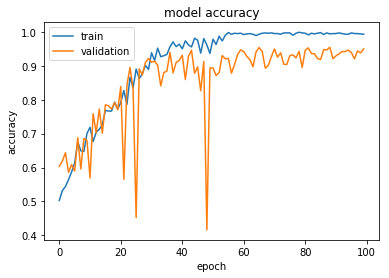

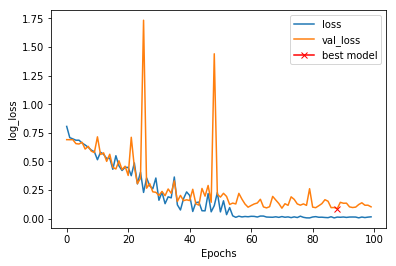

In [13]:
history_plot(history)

In [14]:
# Load CheckPoint
# from keras.models import load_model
# model= load_model('./checkpoint/model_check_2019-03-14_1_fit.h5')

In [30]:
model.evaluate_generator(generator=validation_generator,
#                          steps=validation_generator.classes.shape[0]//32 +1,
                         steps=validation_generator.classes.shape[0],
                         verbose=1)

1243/1243 [==============================] - 864s 695ms/step


[0.11679165855613304, 0.9406123016114123]

In [26]:
# predict the output
Y_pred = model.predict_generator(validation_generator,
                                 steps=num_of_test_samples//32 +1,
                                 verbose=1)

39/39 [==============================] - 30s 758ms/step


In [34]:
Y_pred

array([[2.1068077e-16],
       [2.0816583e-07],
       [2.1146565e-25],
       ...,
       [2.8365272e-07],
       [4.3803061e-13],
       [1.8527831e-09]], dtype=float32)

In [35]:
auc = roc_auc_score(validation_generator.classes,Y_pred)
print("AUC: {}".format(auc))
# fpr, tpr, thresholds = roc_curve(validation_generator.classes, Y_pred)

AUC: 0.9477346864806089


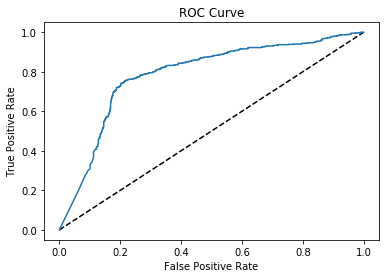

In [36]:
# Plot ROC curve
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='AUC = %0.2f' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# plt.show()
plt.savefig("roc_curve.png",dpi=300)

In [19]:
# read image function , used to make ,but now is useless
def read_dir_img(dir_path,cell):
    all_img=[]
    label=[]
    for filename in os.listdir(dir_path):
        if cell == 'EOSINOPHIL':
            label.append(0)
        elif cell == 'LYMPHOCYTE':
            label.append(1)
        else :
            pass
        
        img = cv2.imread(dir_path + "/"+filename)
        img = scipy.misc.imresize(arr=img,size=(80,60,3))
        img_arr = np.asarray(img)
        
        all_img.append(img_arr)
        
    image_all=np.asarray(all_img)/255
    return (image_all),(label)